Mini-DEG:
1. turn smiles into graph
2. given graph, randomly sample subgraphs
   a. Each sampled subgraph is contracted and becomes a production rule
   b. Contracted node is designated "non-terminal node"
3. last one is contracted into initial node

Reverse process for generation

Implementing:

![figure](fig.png)

### Data stuff

In [1]:
from rdkit import Chem
import networkx as nx
import random
import itertools

In [2]:
# load samples from samples.txt

with open('samples.txt', 'r') as f:
    samples = f.readlines()

samples

['O=C=C=NCN=C=O\n',
 'CC1=C=NC=NCC(=C=O)C=C1\n',
 'O=C=NC1=CC=CC2(C3=CC=C4C=CCCN=CC=C(C=NCC3)C4)CCCCCC(=C1)CC2\n',
 'Cc1cccc(C)c1\n',
 'Cc1ccc(CC2=CC=C(CC3=CCN=CC=C3)CCN=C2)cc1\n',
 'CC(C)(CCCON=C=O)CCOCN=O\n',
 'O=C=NC(N=C=O)=NC1=CC2=CC=NCCC=C=NC(=C=O)C(=CC=C1)C2\n',
 'O=C=NCCC1CCC(N=C=O)CC1\n',
 'CC(N=C=O)C(C)C(=O)C1CCCCCCCC1\n',
 'CC1=CC=CC(C2=CC=C3C=CCCN=C=CC=C(C=C=NCC2)C3)N=C=C1\n']

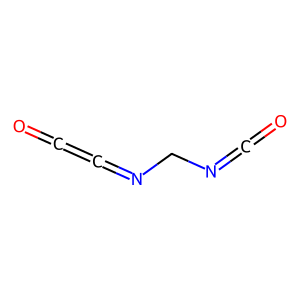

In [3]:
sample = samples[0]
m = Chem.MolFromSmiles(sample)

# display molecule
from rdkit.Chem import Draw
Draw.MolToImage(m)

In [4]:
def mol_to_graph(mol):
    g = nx.Graph()
    for atom in mol.GetAtoms():
        g.add_node(atom.GetIdx(), element=atom.GetSymbol())
    for bond in mol.GetBonds():
        g.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType())
    return g

def graph_to_mol(g):
    mol = Chem.RWMol()
    for node, data in g.nodes(data=True):
        mol.AddAtom(Chem.Atom(data['element']))
    for u, v, data in g.edges(data=True):
        mol.AddBond(u, v, data['bond_type'])
    Chem.SanitizeMol(mol)
    return mol.GetMol()

{(0, 1): Text(-0.43132041705406593, -0.7900196328439839, 'DOUBLE'),
 (1, 2): Text(-0.22256496404898407, -0.6013939129691133, 'DOUBLE'),
 (2, 3): Text(-0.03130712857432839, -0.3478954015642831, 'DOUBLE'),
 (3, 4): Text(0.11677448186072553, -0.051851264566494956, 'SINGLE'),
 (4, 5): Text(0.21022116348976866, 0.2676797588264249, 'SINGLE'),
 (5, 6): Text(0.25376152953096665, 0.5854935044247944, 'DOUBLE'),
 (6, 7): Text(0.2524063821386257, 0.8702352755818419, 'DOUBLE')}

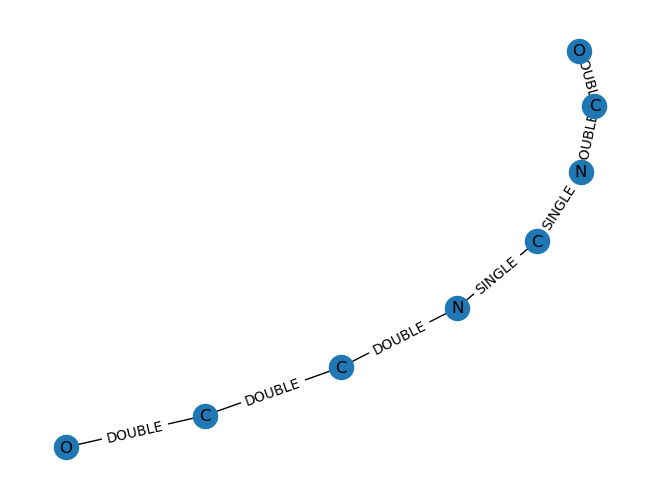

In [5]:
G = mol_to_graph(m)
pos=nx.spring_layout(G)
nx.draw(G, pos, labels={n: d['element'] for n, d in G.nodes(data=True)})
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['bond_type'] for u, v, d in G.edges(data=True)})

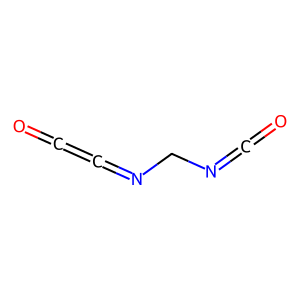

In [6]:
M = graph_to_mol(G)
Draw.MolToImage(M)

### Extract subgraphs

/tmp/ipykernel_14017/3223599961.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subgraph = G.subgraph(random.sample(G.nodes(), random.randint(2, len(G.nodes())-1)))


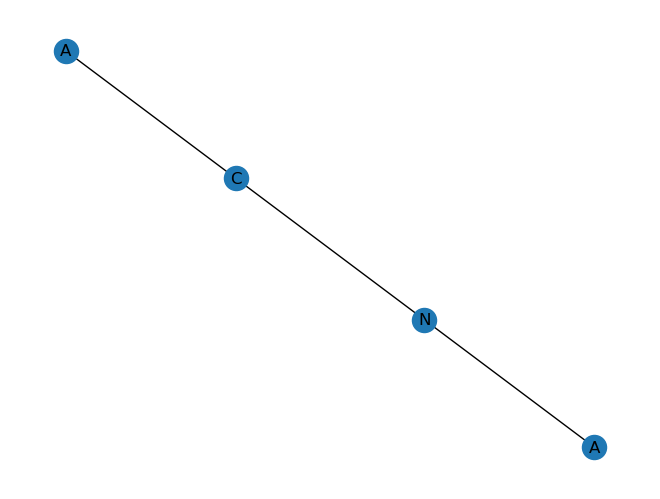

In [7]:
# randomly draw out subgraphs (later on will replace with optimizable edge weights)

def get_subgraph(G):
    while True:
        if G.number_of_nodes() == 1 or G.number_of_nodes() == 2:
            return G
        
        subgraph = G.subgraph(random.sample(G.nodes(), random.randint(2, len(G.nodes())-1)))
        if nx.is_connected(subgraph):
            # add anchor nodes to where the subgraph is connected to the rest of the graph, with proper bond types
            for node in subgraph.nodes():
                for neighbor in G.neighbors(node):
                    if neighbor not in subgraph.nodes():
                        subgraph = subgraph.copy()
                        subgraph.add_node(neighbor, element="A")
                        subgraph.add_edge(node, neighbor, bond_type=G[node][neighbor]['bond_type'])

            return subgraph
    
subgraph = get_subgraph(G)
# print(subgraph.nodes(data=True))
pos=nx.spring_layout(subgraph)
nx.draw(subgraph, pos, labels={n: d['element'] for n, d in subgraph.nodes(data=True)})

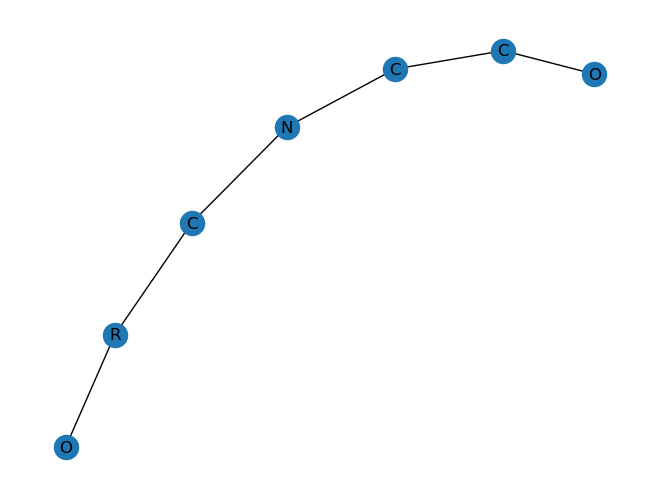

In [8]:
# replace subgraph in graph with non-terminal node

def contract_node(Gc, subgraph):
    
    Gc = G.copy()   
    s_nodes = [n for n in subgraph.nodes() if subgraph.nodes[n]['element'] != 'A']

    # get neighboring edges of subgraph
    neighbors = []
    for node in s_nodes:
        for neighbor in Gc.neighbors(node):
            if neighbor not in s_nodes:
                neighbors.append(neighbor)

    Gc.remove_nodes_from(s_nodes)
    
    # if no nodes left, return empty graph
    if len(Gc.nodes()) == 0:
        return nx.Graph()
    
    # add node in place of subgraph
    idx = max(Gc.nodes()) + 1
    Gc.add_node(idx, element='R')

    # add edges between new node and neighbors of subgraph
    for node in neighbors:
        Gc.add_edge(idx, node, bond_type=Chem.rdchem.BondType.SINGLE)

    return Gc

G = contract_node(G, subgraph)
pos=nx.spring_layout(G)
nx.draw(G, pos, labels={n: d['element'] for n, d in G.nodes(data=True)})

In [9]:
# store production rules in class

class ProductionRule:
    def __init__(self, lhs: nx.Graph, rhs: nx.Graph):
        self.lhs = lhs
        self.rhs = rhs
        
    def __repr__(self):
        # return elements of lhs and rhs
        lhs = [n[1]['element'] for n in self.lhs.nodes(data=True)]
        rhs = [n[1]['element'] for n in self.rhs.nodes(data=True)]
        return f'{lhs} -> {rhs}'

class ProductionRules:
    def __init__(self):
        self.rules = []
        
    def add_rule(self, rule: ProductionRule):
        self.rules.append(rule)
        
    def __repr__(self):
        return f'{self.rules}'
    
    def __len__(self):
        return len(self.rules)

LHS


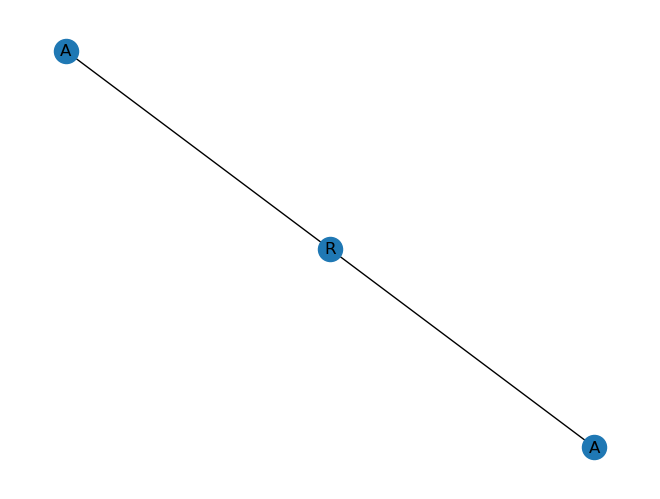

In [10]:
# turn subgraph into production rule

def to_production_rule(G, subgraph):
    """
    lhs is R and adjacent nodes, rhs is R and subgraph
    """
    rhs = subgraph.copy()
    # rhs = nx.relabel_nodes(subgraph, {n: d['element'] for n, d in subgraph.nodes(data=True)})   # relabel nodes with element, not index

    lhs = nx.Graph()
    if G.number_of_nodes() == 0:
        lhs.add_node(0, element='X')    # initial node
    else:
        lhs.add_node(0, element='R')

        for n in G.neighbors(max(G.nodes())):
            if G.nodes[n]['element'] != 'R':
                # lhs.add_node(max(lhs.nodes())+1, element=G.nodes[n]['element'])
                lhs.add_node(max(lhs.nodes())+1, element='A')   # anchor node
                lhs.add_edge(0, max(lhs.nodes()), bond_type=G.edges[(max(G.nodes()), n)]['bond_type'])
            elif G.nodes[n]['element'] == 'R':
                lhs.add_node(max(lhs.nodes())+1, element='R')
                lhs.add_edge(0, max(lhs.nodes()), bond_type=G.edges[(max(G.nodes()), n)]['bond_type'])

    return ProductionRule(lhs, rhs)

prod = to_production_rule(G, subgraph)

print("LHS")
pos=nx.spring_layout(prod.lhs)
nx.draw(prod.lhs, pos, labels={n: d['element'] for n, d in prod.lhs.nodes(data=True)})

RHS


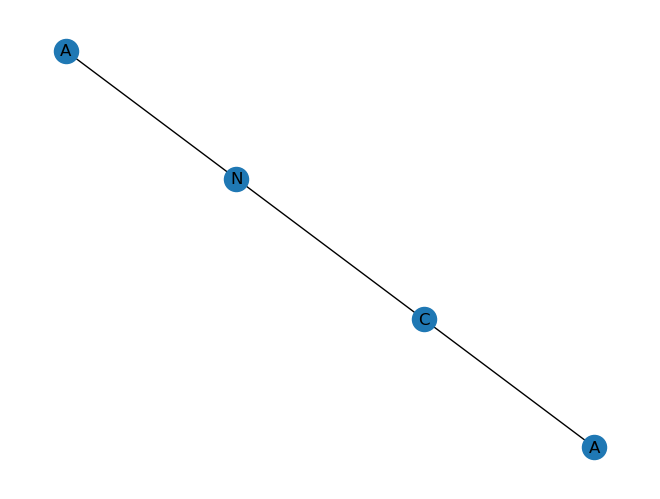

In [11]:
print("RHS")
pos = nx.spring_layout(prod.rhs)
nx.draw(prod.rhs, pos, labels={n: d['element'] for n, d in prod.rhs.nodes(data=True)})

In [12]:
print(prod.lhs.nodes(data=True))
print(prod.rhs.nodes(data=True))

[(0, {'element': 'R'}), (1, {'element': 'A'}), (2, {'element': 'A'})]
[(5, {'element': 'N'}), (6, {'element': 'C'}), (4, {'element': 'A'}), (7, {'element': 'A'})]


In [13]:
# add production rule to production rules

rules = ProductionRules()
rules.add_rule(prod)
len(rules)

1

### Full cycle of contracting molecule and getting production rules

{(0, 1): Text(-0.6705166887015159, -0.8599959334706585, 'DOUBLE'),
 (1, 2): Text(-0.5165971254551192, -0.5614291213448837, 'DOUBLE'),
 (2, 3): Text(-0.3136326146990802, -0.2440251295257047, 'DOUBLE'),
 (3, 4): Text(-0.06970613861825153, 0.062171600253941535, 'SINGLE'),
 (4, 5): Text(0.20640276452353437, 0.3397184933887673, 'SINGLE'),
 (5, 6): Text(0.4984683964781007, 0.5778367533353854, 'DOUBLE'),
 (6, 7): Text(0.7777465388770617, 0.7643025696075962, 'DOUBLE')}

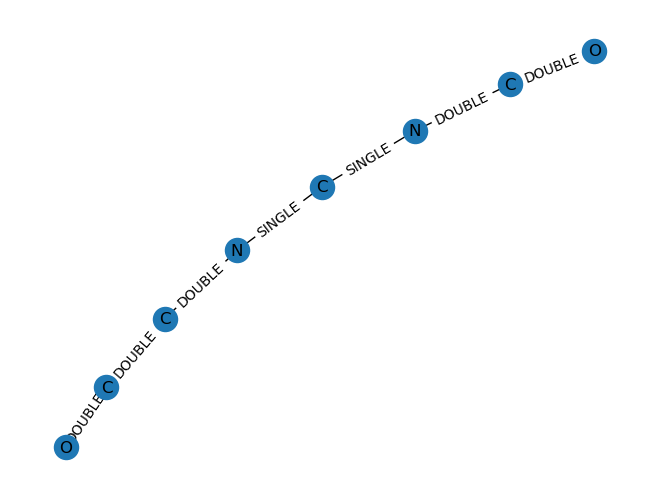

In [185]:
G = mol_to_graph(m)
pos=nx.spring_layout(G)
nx.draw(G, pos, labels={n: d['element'] for n, d in G.nodes(data=True)})
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['bond_type'] for u, v, d in G.edges(data=True)})

In [186]:
rules = ProductionRules()

while G.number_of_nodes() > 0:
    subgraph = get_subgraph(G)
    G = contract_node(G, subgraph)
    print(G.nodes(data=True))
    prod = to_production_rule(G, subgraph)
    rules.add_rule(prod)    # TODO: check to make sure rule is not already in rules (prob do this in ProductionRules class)

[(0, {'element': 'O'}), (7, {'element': 'O'}), (8, {'element': 'R'})]
[(0, {'element': 'O'}), (1, {'element': 'R'})]
[]


/tmp/ipykernel_14017/3223599961.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subgraph = G.subgraph(random.sample(G.nodes(), random.randint(2, len(G.nodes())-1)))


In [197]:
rules.rules

[['R', 'A', 'A'] -> ['C', 'C', 'N', 'C', 'N', 'C', 'A', 'A'],
 ['R', 'A'] -> ['O', 'R', 'A'],
 ['X'] -> ['R']]

### (Re)generate  molecule

In [188]:
def get_all_subgraphs(G, n):
    """
    Get all subgraphs of size n
    """
    subgraphs = []
    for nodes in itertools.combinations(G.nodes(), n):
        subgraph = G.subgraph(nodes)
        if nx.is_connected(subgraph):
            subgraphs.append(subgraph)
    return subgraphs

In [189]:
def select_prod_rule(G, rules):
    """
    randomly iterate through rules and check if rule can be applied to each subgraph
    for each rule, iterate through subgraphs and check if rule can be applied
    """
    
    random.shuffle(rules)
    for rule in rules:
        for subgraph in get_all_subgraphs(G, len(rule.lhs.nodes())):
            if nx.is_isomorphic(subgraph, rule.lhs, node_match=lambda n1, n2: n1['element'] == n2['element'] or n1['element'] == 'A' or n2['element'] == 'A', edge_match=lambda e1, e2: e1['bond_type'] == e2['bond_type']):
                print(f'rule {rule} can be applied to subgraph {subgraph}')
                return rule, subgraph
    return None

In [190]:
# # test for select_prod_rule

# G_test = nx.Graph()
# G_test.add_nodes_from([(0, {'element': 'C'}), (1, {'element': 'R'})])
# G_test.add_edges_from([(0, 1, {'bond_type': Chem.rdchem.BondType.SINGLE})])
# test = select_prod_rule(G_test, rules.rules)
# apply_prod_rule(G_test, test[0], test[1])

In [195]:
def apply_prod_rule(G, rule, subgraph):
    """
    apply production rule to subgraph and return new graph
    """

    # if starting graph, replace X with rhs
    if G.number_of_nodes() == 1:
        return rule.rhs

    # match subgraph to lhs of rule
    GM = nx.algorithms.isomorphism.GraphMatcher(subgraph, rule.lhs, node_match=lambda n1, n2: n1['element'] == n2['element'] or n1['element'] == 'A' or n2['element'] == 'A', edge_match=lambda e1, e2: e1['bond_type'] == e2['bond_type'])
    GM.subgraph_is_isomorphic()
    sg_mapping = GM.mapping    # subgraph to lhs mapping
    print(subgraph.nodes(data=True), rule.lhs.nodes(data=True), sg_mapping)
    
    # TODO: replace subgraph in G with rhs of rule

In [196]:
generated = nx.Graph()
generated.add_node(0, element='X')

# apply rules to generate new graph

curr_rules = rules.rules

while any([d['element'] == 'R' or d['element'] == 'X' for n, d in generated.nodes(data=True)]):    # while there are still R (non-terminal) nodes
    rule, subgraph = select_prod_rule(generated, curr_rules)
    generated = apply_prod_rule(generated, rule, subgraph)
        
    print(generated.nodes(data=True))
    print(generated.edges(data=True))
    
pos=nx.spring_layout(generated)
nx.draw(generated, pos, labels={n: d['element'] for n, d in generated.nodes(data=True)})

rule ['X'] -> ['R'] can be applied to subgraph Graph with 1 nodes and 0 edges
[(1, {'element': 'R'})]
[]


TypeError: cannot unpack non-iterable NoneType object